In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.integrate import quad
from scipy.special import sph_harm
from scipy.optimize import fsolve
import time

S = 600*(1-0.2)
sigma_SB = 5.67e-8
g = 9.8
cp = 1000
bar = 10**5
z = 1000
H = 8500
R = 188 # Earth-like composition
Tskin = 2**(-1/4) * (S/(4*sigma_SB))**(1/4)
Cs_land = 1000000 # LMDZ

Cs_atm = cp*1*bar/g

n = 2*np.pi/(224*60*60*24)
D = 1.66


# define bounds of sensitivity tests

tau_lw_list = 10**np.linspace(-3,2, 20)
tau_sw_list = 10**np.linspace(-3,1, 20)
n = 2*np.pi/(224*60*60*24) # Venus, orbital period of 224 days
Omega_list = np.linspace(-15*n, 15*n, 31)
S_list = np.linspace(0.25*1366, 1.5*1366, 30)
alpha_list = np.linspace(0.05,0.9, 10)
ps_list = 10**np.linspace(-1, 2, 10)


In [2]:
def p_from_T(save, mean_p,tau_lw, tau_sw, S_in):
    k = tau_sw/tau_lw
    SLW = S_in/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw))
    F_bar = quad(lambda lam: S_in*np.exp(-tau_sw)*np.maximum(np.cos(lam),0), 0, 2*np.pi)[0]/(2*np.pi)
    T_bar = np.power((F_bar+SLW)/sigma_SB,1/4)
    z = 1500
    R = 188
    H = R*save/g
    rho_o = mean_p/(R*T_bar)
    #p = mean_p-mean_p*cp/R*(save-mean_T)/mean_T
    p = mean_p-rho_o*g*z*(save)/T_bar *(tau_lw)**(1/3)

    return(p)

def pressure(phi_int, which, lam):
    return(np.interp(phi_int, lam, which))

def complex_mom_pressure(m, which, x_data):
    p2_imag = quad(lambda phi: np.imag(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, which, x_data), 0, 2*np.pi)[0]
    p2_real = quad(lambda phi: np.real(np.conj(sph_harm(m,2,phi,np.pi/2))) * pressure(phi, which, x_data), 0, 2*np.pi)[0]
    return(p2_real + 1j*p2_imag)

def quad_moment_1d(data, x_data, press,tau_lw, tau_sw, S_in):
    p_save = p_from_T(data, press,tau_lw, tau_sw, S_in)
    p22 = complex_mom_pressure(2, np.array(p_save), x_data)
    p2m2 = complex_mom_pressure(-2, np.array(p_save), x_data)
    arg = np.arctan(np.imag(p22)/np.real(p22))
    offset = np.sin(2*0 - arg)
    curve = p22*sph_harm(2,2, x_data, np.pi/2)+ p2m2*sph_harm(-2,2, x_data, np.pi/2)
    amp = (np.max(curve) - np.min(curve))/2
    im_qa = np.absolute(p22) * offset
    return([np.absolute(p22), im_qa, offset, curve])

def get_torque_info(sol, ps, lam_plot,tau_lw, tau_sw, S_in):

    im_q = np.zeros(len(sol))
    amp = np.zeros(len(sol))
    lag = np.zeros(len(sol))

    for i in range(len(sol)):
        im_q[i] = quad_moment_1d(sol[i,:], lam_plot, ps,tau_lw, tau_sw, S_in)[1]
        amp[i] = quad_moment_1d(sol[i,:], lam_plot, ps,tau_lw, tau_sw, S_in)[0]
        lag[i] = quad_moment_1d(sol[i,:], lam_plot, ps,tau_lw, tau_sw, S_in)[2]
    return(im_q, amp, lag)

In [29]:
def T_lam_locked(dT, lam, S, F_bar, T_bar): # for zero forcing, use fsolve 
    cos_zenith = np.cos(lam)
    return((S*np.maximum(cos_zenith,0) - F_bar - 4*sigma_SB*T_bar**3*dT)) # dTdt = F_in - F_out # dTdt = F_in - F_out 

def ddTdlam(lam, dT, T_bar, F_bar, forcing, Cs, S): 
    cos_zenith = np.cos(lam)
    return((S*np.maximum(cos_zenith,0) - F_bar - 4*sigma_SB*T_bar**3*dT)/(forcing*Cs)) # dTdt = F_in - F_out

def do_T_lam_locked(tau_lw, tau_sw, S_in, lam_plot, guess):
    lam_list = np.linspace(0, 2*np.pi, 200)
    sol = np.zeros(len(lam_list))
    k = tau_sw/tau_lw
    SLW = S_in/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw))
    F_bar = quad(lambda lam: S_in*np.maximum(np.cos(lam),0), 0, 2*np.pi)[0]/(2*np.pi)
    T_bar = np.power((F_bar+SLW)/sigma_SB,1/4)
    j = 0
    for lam in lam_list:
        sol[j] = fsolve(T_lam_locked, guess, args = (lam, S_in, F_bar, T_bar))
        j +=1
    return(np.interp(lam_plot,lam_list, sol))


def T_lam_centered(forcing, ps, S_in, periods_needed, res, N_cycles, z, tau_sw, tau_lw, guess):
    S_model = S_in*np.exp(-tau_sw)
    lamda = 0
    delt_p = ps*(1-np.exp(-1000/H))
    Cs = delt_p/g * cp + Cs_land
    #lam_list = np.linspace(0, (periods_needed+N_cycles)*(2*np.pi), res*(periods_needed+N_cycles))
    if forcing > 0: # super-syncronous
        lam_list = np.linspace(0, 2*np.pi, res)
        lam_list_full = np.linspace(0, (periods_needed+N_cycles)*(2*np.pi), res*(periods_needed+N_cycles))
    elif forcing < 0: # sub-syncronous
        lam_list = np.linspace(2*np.pi,0, res)
        lam_list_full = np.linspace((periods_needed+N_cycles)*(2*np.pi), 0, res*(periods_needed+N_cycles))
    lammin = lam_list[0]
    lammax = lam_list[-1]
    T0 = 0
    k = tau_sw/tau_lw
    SLW = S_in/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw))
    F_bar = quad(lambda lam: S_in*np.maximum(np.cos(lam),0), 0, 2*np.pi)[0]/(2*np.pi)
    T_bar = np.power((F_bar+SLW)/sigma_SB,1/4)
    print(T_bar)
    T_phi = np.zeros(len(lam_list_full))
    sol = odeint(ddTdlam, T0, lam_list_full,args = (T_bar, F_bar,forcing, Cs, S_model), tfirst=True)
    sol_stacked = np.reshape(sol, [N_cycles+periods_needed, res])

    avg_stacked = np.nanmean(sol_stacked[-N_cycles:,:], axis = 0)
    sorted_index = np.argsort(lam_list)
    return(avg_stacked[sorted_index])


In [30]:
def run_ExoTides(tau_lw, tau_sw, ps, n,res, periods_needed, S_in, Omega_list, guess):
    Tskin = 2**(-1/4) * (S_in/(4*sigma_SB))**(1/4)
    delt_p = ps*(1-np.exp(-z/H)) 
    Cs = delt_p/g * cp
    N_cycles = 40
    lam_plot = np.linspace(0, 2*np.pi, res)
    sol = np.zeros([len(Omega_list), len(lam_plot)])
    #start_time = time.time()
    for i in range(len(Omega_list)):
        Omega = Omega_list[i]
        forcing = Omega-n
        if np.isclose(forcing,0, rtol = 1e-2):
            sol[i,:] = do_T_lam_locked(tau_lw, tau_sw, S_in, lam_plot, guess)
        else:
            sol[i,:] = T_lam_centered(forcing, ps, S_in, periods_needed, res, N_cycles, z, tau_sw, tau_lw, guess)
            

    #end_time = time.time()
    
    #print(end_time - start_time)
    return(sol)


In [35]:
Omega_list = [1*n]#np.linspace(5*n, 15*n, 20)

sol_spinup = run_ExoTides(1, 0.00001, 1*bar, n,1000, 600, 1137*(0.8), Omega_list, 300)

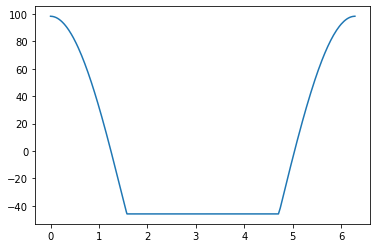

In [38]:
lam_list = np.linspace(0,2*np.pi, len(sol_spinup[0,:]))
S_in = 1137*0.8
tau_lw = 1
tau_sw = 0.00001
k = tau_sw/tau_lw
SLW = S_in/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw))
F_bar = quad(lambda lam: S_in*np.exp(-tau_sw)*np.maximum(np.cos(lam),0), 0, 2*np.pi)[0]/(2*np.pi)
T_bar = np.power((F_bar+SLW)/sigma_SB,1/4)
    
    
    
    
for i in range(len(Omega_list)):
    plt.plot(lam_list, sol_spinup[i,:])
#plt.ylim(230,400)  

In [26]:
T_bar

303.0563732702677

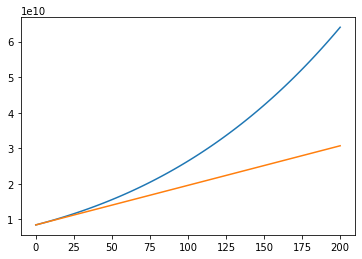

In [46]:
delt_T = np.linspace(0,200,100)

plt.plot(delt_T, (T_bar+delt_T)**4)
plt.plot(delt_T, T_bar**4*(1+4*delt_T/T_bar))